# Imports

In [45]:
from pathlib import Path
from datetime import datetime
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

# Global settings

In [2]:
ROOT_PATH = Path(r'Z:\Ella')
EXPERIMENT_NAME = '5_sec_const'
FILES_TO_LOAD = [
    "angle_timeseries",
    "opto_rec",
    "speed_rec", 
    "swim_info_after", # swim info = {startSwimInd   -> in frames   
                                    # endSwimInd      -> in frames
                                    # swim_duration      -> in ms
                                    # swim_bout_num      ? 
                                    # swim_max_signal     -> f/f0? 
                                    # swim_mean_signal      
                                    # swim_LR_balance      -> between o to 1, 1 represents imbalance 
                                    # swim_frequency } -> ?
    "swim_info_before",
    "swim_info_during"
]

STIM_CONFIGS = {
    "5_sec_const": {
        "start_sec": 600,
        "duration_sec": 5.0,
        "type": "constant",   # Continuous light
        "tolerance_sec": 1.0  # Allow 1s shift in start time
    },
    "30_sec_interval": {
        "start_sec": 600,
        "duration_sec": 30.0,
        "type": "interval",   # Pulsed light (checking total bounds only)
        "tolerance_sec": 1.0
    }
}

FRAMES_BEFORE = 10 * 60 *400 # 10 min
FRAMES_DURING = 5 * 400 # 5 sec 
FRAMES_AFTER  = (20*60*400) - (FRAMES_BEFORE + FRAMES_DURING) # 20 min is the exp len, substarct the other stages. 

# Calculate the cut points in the global file
T0 = 0
T1 = FRAMES_BEFORE                    # End of 'Before', Start of 'During'
T2 = FRAMES_BEFORE + FRAMES_DURING    # End of 'During', Start of 'After'
T3 = T2 + FRAMES_AFTER

# Data loading

In [3]:
records = []
exp_dict = {
    EXPERIMENT_NAME: defaultdict(dict)
}
experiment_path = ROOT_PATH / EXPERIMENT_NAME

for date_dir_name in experiment_path.iterdir():
    date = datetime.strptime(date_dir_name.stem, "%Y%m%d").date()
    
    for fish_dir_name_path in (experiment_path / date_dir_name).iterdir():
        full_fish_name = fish_dir_name_path.stem.removesuffix("_Exp00").removesuffix("_" + EXPERIMENT_NAME)
        fish_id = full_fish_name.split("_")[0]
        group_name = "_".join(full_fish_name.split("_")[1:])

        records.append({
            "path": str(fish_dir_name_path),
            "date": date,
            "fish_id": fish_id,
            "group_name": group_name,
        })

        exp_dict[EXPERIMENT_NAME][group_name][fish_id] = {
            key: np.load(fish_dir_name_path / f"{key}.npy", allow_pickle=True)
            for key in FILES_TO_LOAD
        }
        
df = pd.DataFrame.from_records(records)

# Raw data exploration

## data structure

In [4]:
exp_dict.keys()

dict_keys(['5_sec_const'])

In [5]:
exp_dict["5_sec_const"].keys()  # group_id

dict_keys(['narp_neg', 'narp_pos'])

In [6]:
exp_dict["5_sec_const"]["narp_neg"].keys()  # fish id (unique only inside group)

dict_keys(['F1', 'F2', 'F3', 'F4', 'F5', 'F6'])

In [7]:
exp_dict["5_sec_const"]["narp_neg"]["F1"].keys()  # npy files

dict_keys(['angle_timeseries', 'opto_rec', 'speed_rec', 'swim_info_after', 'swim_info_before', 'swim_info_during'])

## explore per `npy`

### `angle_timeseries`

In [8]:
exp_dict["5_sec_const"]["narp_neg"]["F1"]["angle_timeseries"].shape

(479816,)

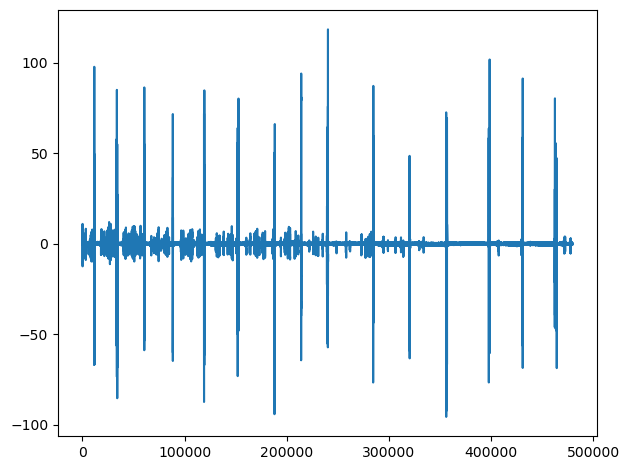

In [26]:
a = exp_dict["5_sec_const"]["narp_neg"]["F1"]["angle_timeseries"]
plt.figure
plt.plot(a)

plt.tight_layout() 
plt.show()

### `opto_rec`

In [9]:
exp_dict["5_sec_const"]["narp_neg"]["F1"]["opto_rec"].shape

(479816,)

In [10]:
exp_dict["5_sec_const"]["narp_neg"]["F1"]["opto_rec"]

array([0, 0, 0, ..., 0, 0, 0])

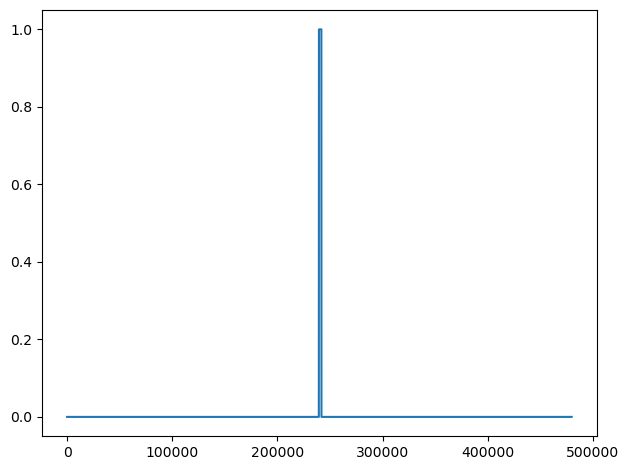

In [11]:
y = exp_dict["5_sec_const"]["narp_pos"]["F1"]["opto_rec"]
plt.figure
plt.plot(y)

plt.tight_layout() 
plt.show()

### `speed_rec`

In [12]:
exp_dict["5_sec_const"]["narp_neg"]["F1"]["speed_rec"].shape

(479816,)

In [13]:
x = exp_dict["5_sec_const"]["narp_neg"]["F1"]["speed_rec"]

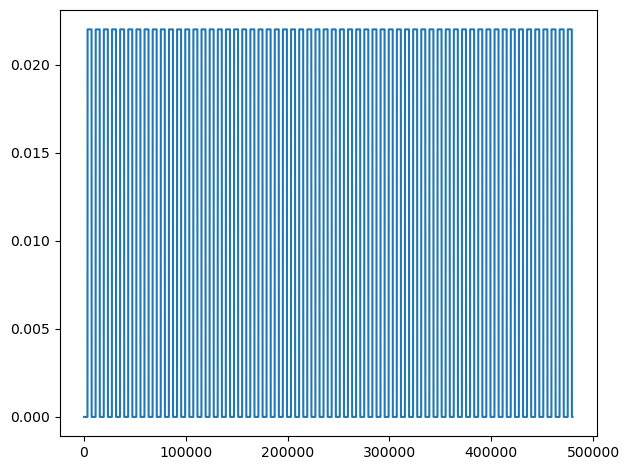

In [14]:
plt.figure
plt.plot(x)

plt.tight_layout() 
plt.show()

### `swim_info_after`

In [15]:
exp_dict["5_sec_const"]["narp_neg"]["F1"]["swim_info_after"].item()

{'startSwimInd': array([  6791.,  15905.,  16201.,  19685.,  20058.,  31021.,  31297.,
         35132.,  36923.,  37818.,  39279.,  40702.,  42629.,      0.,
         52348.,  52773.,  57099.,  64090.,  64597.,  69838.,  72065.,
         78283.,  87706.,  92056., 114122., 114463., 155798., 156166.,
        156612., 165539., 188655., 189060., 220471., 220951., 221286.,
        222389., 229795., 230158., 230653., 235729., 236052.]),
 'endSwimInd': array([  6817.,  15929.,  16270.,  19712.,  20069.,  31094.,  31385.,
         35222.,  37022.,  37891.,  39355.,  40805.,  42837.,      0.,
         52359.,  52833.,  57149.,  64130.,  64639.,  69914.,  72119.,
         78539.,  87729.,  92118., 114243., 114971., 155935., 156288.,
        156726., 165604., 188694., 189231., 220674., 221050., 221450.,
        222431., 229847., 230234., 230699., 235824., 236111.]),
 'swim_duration': array([  65. ,   60. ,  172.5,   67.5,   27.5,  182.5,  220. ,  225. ,
         247.5,  182.5,  190. ,  257.5,  52

In [16]:
keys_lst = list(exp_dict["5_sec_const"]["narp_neg"]["F1"]["swim_info_after"].item().keys())
for k in keys_lst:
    print(k, "     shape: ", exp_dict["5_sec_const"]["narp_neg"]["F1"]["swim_info_after"].item()[k].shape)

startSwimInd      shape:  (41,)
endSwimInd      shape:  (41,)
swim_duration      shape:  (41,)
swim_bout_num      shape:  (41,)
swim_max_signal      shape:  (41,)
swim_mean_signal      shape:  (41,)
swim_LR_balance      shape:  (41,)
swim_frequency      shape:  (41,)


### `swim_info_before`

In [17]:
exp_dict["5_sec_const"]["narp_neg"]["F1"]["swim_info_before"].item()

{'startSwimInd': array([2.90000e+01, 2.38700e+03, 3.20600e+03, 5.96300e+03, 7.30800e+03,
        8.02200e+03, 8.67300e+03, 9.51500e+03, 1.02350e+04, 1.14260e+04,
        1.81010e+04, 1.85140e+04, 2.00930e+04, 2.05180e+04, 2.07300e+04,
        2.13800e+04, 2.34400e+04, 2.38710e+04, 2.41090e+04, 2.53330e+04,
        2.60190e+04, 2.68110e+04, 2.76050e+04, 2.88430e+04, 2.99160e+04,
        3.13860e+04, 3.22970e+04, 3.34640e+04, 3.39510e+04, 3.98000e+04,
        4.01310e+04, 4.04530e+04, 4.21220e+04, 4.25030e+04, 4.42730e+04,
        4.51430e+04, 4.69920e+04, 4.81580e+04, 4.91130e+04, 4.99080e+04,
        5.06970e+04, 5.16830e+04, 5.33450e+04, 5.57360e+04, 5.63780e+04,
        5.68420e+04, 5.84870e+04, 6.03980e+04, 6.05340e+04, 6.73390e+04,
        6.97650e+04, 7.00600e+04, 7.19150e+04, 7.23360e+04, 7.36950e+04,
        7.45040e+04, 7.68330e+04, 7.75390e+04, 7.97230e+04, 8.00580e+04,
        8.13550e+04, 8.23960e+04, 8.31190e+04, 8.47740e+04, 8.84130e+04,
        9.63720e+04, 9.66320e+04, 9

In [18]:
keys_lst = list(exp_dict["5_sec_const"]["narp_neg"]["F1"]["swim_info_before"].item().keys())
for k in keys_lst:
    print(k, "     shape: ", exp_dict["5_sec_const"]["narp_neg"]["F1"]["swim_info_before"].item()[k].shape)

startSwimInd      shape:  (131,)
endSwimInd      shape:  (131,)
swim_duration      shape:  (131,)
swim_bout_num      shape:  (131,)
swim_max_signal      shape:  (131,)
swim_mean_signal      shape:  (131,)
swim_LR_balance      shape:  (131,)
swim_frequency      shape:  (131,)


### `swim_info_during`

In [19]:
exp_dict["5_sec_const"]["narp_neg"]["F1"]["swim_info_during"].item()

{'startSwimInd': array([140., 493., 766., 971.]),
 'endSwimInd': array([ 277.,  537.,  856., 1265.]),
 'swim_duration': array([342.5, 110. , 225. , 735. ]),
 'swim_bout_num': array([ 46.,  24.,  51., 145.]),
 'swim_max_signal': array([3.05871186, 0.38568374, 0.44378919, 0.52889745]),
 'swim_mean_signal': array([0.23964121, 0.16595304, 0.1520898 , 0.16234459]),
 'swim_LR_balance': array([0.55489856, 0.04040048, 0.01047377, 0.09491629]),
 'swim_frequency': array([ 68.70229008, 112.19512195, 116.27906977,  98.63013699])}

In [20]:
keys_lst = list(exp_dict["5_sec_const"]["narp_neg"]["F1"]["swim_info_during"].item().keys())
for k in keys_lst:
    print(k, "     shape: ", exp_dict["5_sec_const"]["narp_neg"]["F1"]["swim_info_during"].item()[k].shape)

startSwimInd      shape:  (4,)
endSwimInd      shape:  (4,)
swim_duration      shape:  (4,)
swim_bout_num      shape:  (4,)
swim_max_signal      shape:  (4,)
swim_mean_signal      shape:  (4,)
swim_LR_balance      shape:  (4,)
swim_frequency      shape:  (4,)


### `preprocess`

In [41]:
# Create a deep copy to ensure raw data remains untouched
processed_dict = copy.deepcopy(exp_dict)

FS = 400  # Sampling frequency

for exp_name, groups in processed_dict.items():
    for group_name, fishes in groups.items():
        for fish_id, data in fishes.items():

            # Did this fish load all required files?
            missing = [f for f in FILES_TO_LOAD if f not in data.keys()]
            if missing:
                print(f"{fish_id}: Missing files {missing}")
                del exp_dict[processed_dict][group][fish_id]
                continue 
            
            # --- Binarization of Opto and speed of VR Record ---
            # Any signal > 0 is considered 'On' (1)
            for recording in ['opto_rec', 'speed_rec']:
                if recording in data:
                    data['opto_bin'] = (data['opto_rec'] > 0).astype(int)
                    data['speed_bin'] = (data['speed_rec'] > 0).astype(int)

                        # Create the stage-specific arrays
                        # We add these as NEW keys to the fish dictionary
            
                        # BEFORE (Frames 0 to T1)
                    data['opto_before']  = data['opto_bin'][T0:T1]
                    data['speed_before'] = data['speed_bin'][T0:T1]
            
                        # DURING (Frames T1 to T2)
                    data['opto_during']  = data['opto_bin'][T1:T2]
                    data['speed_during'] = data['speed_bin'][T1:T2]
            
                        # AFTER (Frames T2 to T3)
                    data['opto_after']   = data['opto_bin'][T2:T3]
                    data['speed_after']  = data['speed_bin'][T2:T3]
                    
            
            # --- Process Swim Info (Before, During, After) ---
            for stage in ['swim_info_before', 'swim_info_during', 'swim_info_after']:
                if stage in data:
                    # Access the dictionary inside the numpy object
                    swims = data[stage].item() 
                    
                    # Convert indices to time in ms
                    # Start/End are frames -> ms: (frame / 400) * 1000
                    swims['start_ms'] = (swims['startSwimInd'] / FS) * 1000
                    swims['end_ms'] = (swims['endSwimInd'] / FS) * 1000
                    
                    # Create Filtering Mask
                    # Criteria: Duration between 50-400ms AND Frequency > 0 
                    mask = (
                        (swims['swim_duration'] > 50) & 
                        (swims['swim_duration'] < 400) & 
                        (swims['swim_frequency'] > 0) &
                        (swims['startSwimInd'] > 0) # Removing 'fake' bouts at index 0
                    )
                    
                    # Apply Mask to all keys in the swim dictionary
                    for key in swims.keys():
                        swims[key] = swims[key][mask]
                    
                    # Update the dictionary in processed_dict
                    data[stage] = swims

print("Preprocessing Complete")

Preprocessing Complete


In [47]:
processed_dict['5_sec_const']['narp_neg']['F1'].keys()

dict_keys(['angle_timeseries', 'opto_rec', 'speed_rec', 'swim_info_after', 'swim_info_before', 'swim_info_during', 'opto_bin', 'speed_bin', 'opto_before', 'speed_before', 'opto_during', 'speed_during', 'opto_after', 'speed_after'])

In [38]:
processed_dict['5_sec_const']['narp_neg']['F1']['swim_info_before'].keys()

dict_keys(['startSwimInd', 'endSwimInd', 'swim_duration', 'swim_bout_num', 'swim_max_signal', 'swim_mean_signal', 'swim_LR_balance', 'swim_frequency', 'start_ms', 'end_ms'])

### `OMR vs static clasification and means for swim info`

In [43]:
## TODO: make this into a func, sasparate turning the dict into pd from the omr 

# This list will hold our summary data before we turn it into a DataFrame
summary_data = []

# List of parameters you want to analyze
PARAMETERS_TO_ANALYZE = [
    'swim_mean_signal', 
    'swim_max_signal', 
    'swim_duration', 
    'swim_LR_balance', 
    'swim_frequency'
]

# Define stage pairs
stage_pairs = [
    ('speed_before', 'swim_info_before'),
    ('speed_during', 'swim_info_during'),
    ('speed_after',  'swim_info_after')
]

for exp_name, groups in processed_dict.items():
    for group_name, fishes in groups.items():
        for fish_id, data in fishes.items():
            
            for speed_key, swim_key in stage_pairs:
                if speed_key not in data or swim_key not in data:
                    continue

                swims = data[swim_key]
                speed_trace = data[speed_key]
                
                # --- 1. ALIGNMENT LOGIC ---
                start_inds = swims['startSwimInd'].astype(int)
                
                # Safety Filter
                valid_inds_mask = start_inds < len(speed_trace)
                clean_inds = start_inds[valid_inds_mask]
                
                # Get Condition (0 or 1)
                bout_conditions = speed_trace[clean_inds]
                
                # --- 2. AGGREGATION LOOP ---
                for cond_val, cond_name in zip([0, 1], ['Static', 'OMR']):
                    
                    # Create the Condition Mask
                    mask_cond = (bout_conditions == cond_val)
                    
                    # Initialize the row with metadata
                    row_dict = {
                        'Group': group_name,
                        'FishID': fish_id,
                        'Stage': swim_key.replace('swim_info_', ''),
                        'Condition': cond_name,
                        'Bout_Count': np.sum(mask_cond)
                    }
                    
                    # --- YOUR PARAMETER LOOP GOES HERE ---
                    for param in PARAMETERS_TO_ANALYZE:
                        # 1. Retrieve raw array
                        # 2. Apply Safety Mask (valid_inds_mask)
                        # 3. Apply Condition Mask (mask_cond)
                        if param in swims:
                            values = swims[param][valid_inds_mask][mask_cond]
                            
                            if len(values) > 0:
                                row_dict[f'Mean_{param}'] = np.mean(values)
                            else:
                                row_dict[f'Mean_{param}'] = np.nan
                    
                    # Add the finished row to the list
                    summary_data.append(row_dict)

# Create final DataFrame
df_results = pd.DataFrame(summary_data)

# Check the results
print(df_results.head())
print(f"Columns created: {df_results.columns.tolist()}")

      Group FishID   Stage Condition  Bout_Count  Mean_swim_mean_signal  \
0  narp_neg     F1  before    Static          76               5.095770   
1  narp_neg     F1  before       OMR          47               6.341304   
2  narp_neg     F1  during    Static           3               0.185895   
3  narp_neg     F1  during       OMR           0                    NaN   
4  narp_neg     F1   after    Static          19               0.365330   

   Mean_swim_max_signal  Mean_swim_duration  Mean_swim_LR_balance  \
0              8.689408          246.184211              0.082992   
1             12.127734          168.882979              0.151791   
2              1.296062          225.833333              0.201924   
3                   NaN                 NaN                   NaN   
4              0.915933          144.473684              0.155227   

   Mean_swim_frequency  
0            22.218810  
1            21.145465  
2            99.058827  
3                  NaN  
4        

In [22]:
## TODO: otpo clarifying 
##       mean of all traces - with and without OMR 
##       count num of bouts per time bin 
##       frezing rate mean
##       RL balance per time bin? # RL balance per time bin? 